In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        if 'precisions' in data.columns:
            data['precisions'] = data['precisions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        return data
    except Exception as e:
        print(f"Failed to load data from {file_path}: {e}")
        return pd.DataFrame()  

# file paths
evaluation_data = load_data('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/evaluation_log.csv')
training_data = load_data('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/training_output.csv')
summary_data = load_data('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/summary_training_data.csv')

In [2]:
# segment
segments = {
    '1-11': ('blue', 'o'), 
    '12-20': ('green', 's'),  
    '21-28': ('red', 'x')   
}


evaluation_data['segment'] = pd.cut(evaluation_data['iteration'], bins=[0, 11, 20, 28], labels=['1-11', '12-20', '21-28'])
segment_scores = evaluation_data.groupby('segment')['score'].mean()

/var/folders/2l/z97p5p0n1xl2xh458wmv88bw0000gn/T/ipykernel_38024/3649997416.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_scores = evaluation_data.groupby('segment')['score'].mean()


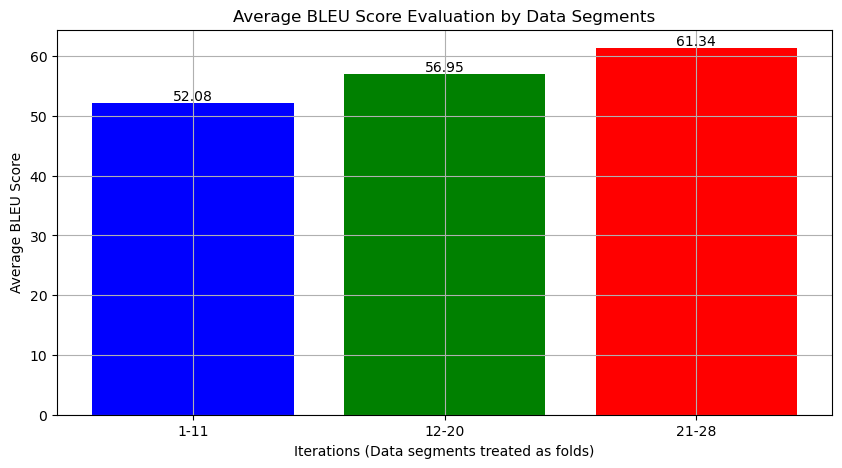

In [5]:
# average BLEU 
plt.figure(figsize=(10, 5))
bars = plt.bar(segment_scores.index, segment_scores.values, color=['blue', 'green', 'red'])
plt.xlabel('Iterations (Data segments treated as folds)')
plt.ylabel('Average BLEU Score')
plt.title('Average BLEU Score Evaluation by Data Segments')

for bar, score in zip(bars, segment_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 2), ha='center', va='bottom')

plt.grid(True)
plt.savefig('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/graphs/Average BLEU for Segment.png')
plt.show()

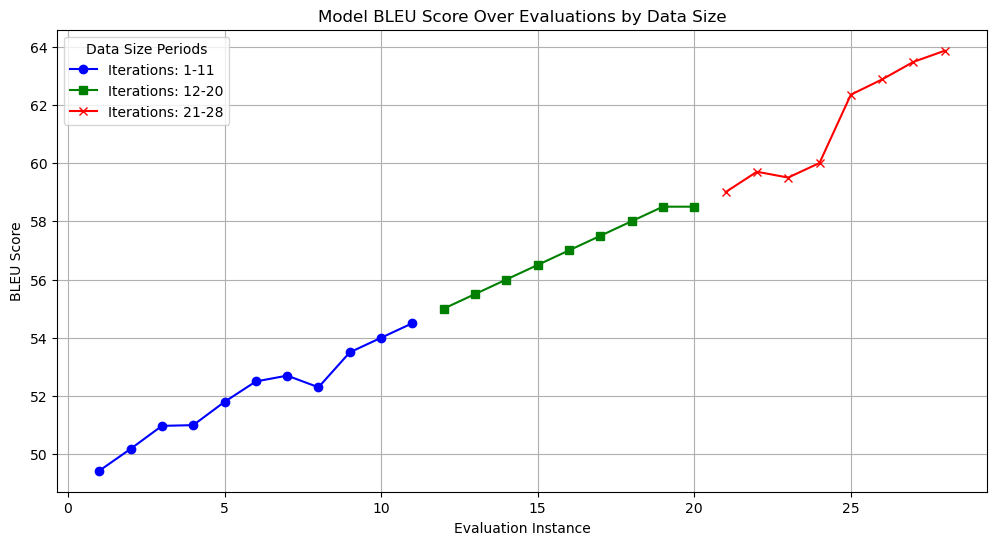

In [6]:
# Plot BLEU Score over Evaluations with segments
plt.figure(figsize=(12, 6))
for key, (color, marker) in segments.items():
    range_start, range_end = map(int, key.split('-'))
    segment_data = evaluation_data[(evaluation_data['iteration'] >= range_start) & (evaluation_data['iteration'] <= range_end)]
    plt.plot(segment_data['iteration'], segment_data['score'], marker=marker, linestyle='-', color=color, label=f'Iterations: {key}')

plt.title('Model BLEU Score Over Evaluations by Data Size')
plt.xlabel('Evaluation Instance')
plt.ylabel('BLEU Score')
plt.legend(title='Data Size Periods')
plt.grid(True)
plt.savefig('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/graphs/bleu_score_plot_segments.png')
plt.show()

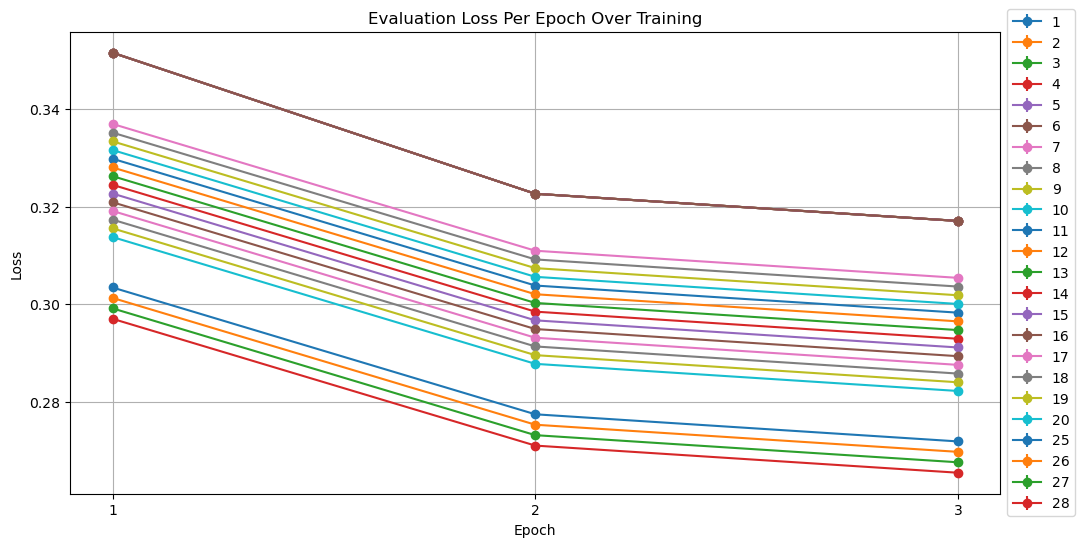

In [7]:
# Plot Training and Evaluation Loss over Epochs with adjustments
plt.figure(figsize=(12, 6))
if not training_data.empty:
    grouped = training_data.groupby(['iteration', 'epoch']).agg({'eval_loss': ['mean', 'std']}).reset_index()
    grouped.columns = ['iteration', 'epoch', 'mean_eval_loss', 'std_eval_loss']
    
    for iteration in grouped['iteration'].unique():
        subset = grouped[grouped['iteration'] == iteration]
        plt.errorbar(subset['epoch'], subset['mean_eval_loss'], yerr=subset['std_eval_loss'], fmt='o-', label=f'{iteration}')

    plt.xticks([1, 2, 3]) 
    plt.title('Evaluation Loss Per Epoch Over Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
    plt.grid(True)
    plt.savefig('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/graphs/evaluation_loss_plot_with_std.png')
    plt.show()

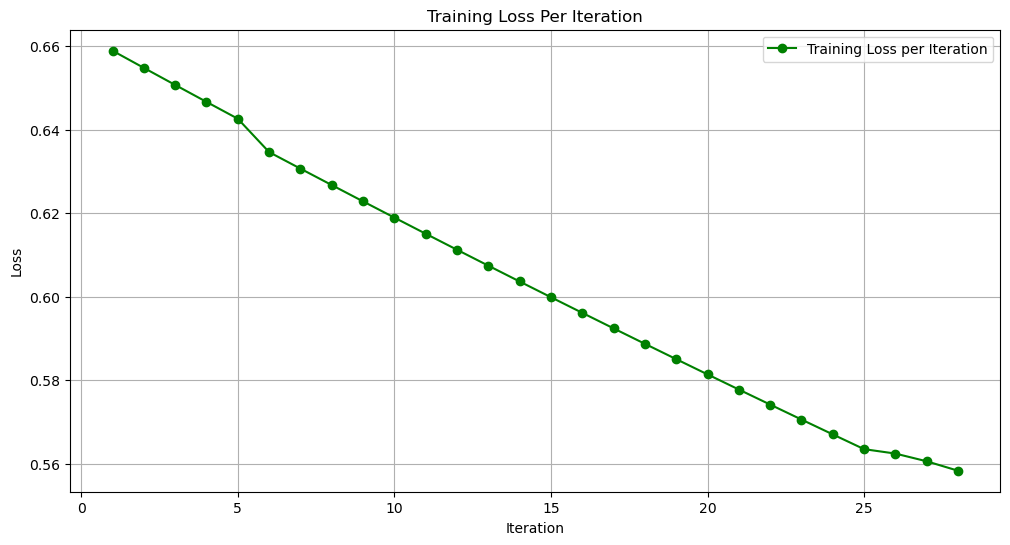

In [8]:
# Plot Summary of Training Loss over Iterations
plt.figure(figsize=(12, 6))
if not summary_data.empty:
    plt.plot(summary_data['iteration'], summary_data['train_loss'], marker='o', linestyle='-', color='green', label='Training Loss per Iteration')
plt.title('Training Loss Per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/graphs/training_loss_plot.png')
plt.show()

stats = training_data.groupby('iteration')['eval_loss'].agg(['mean', 'std'])


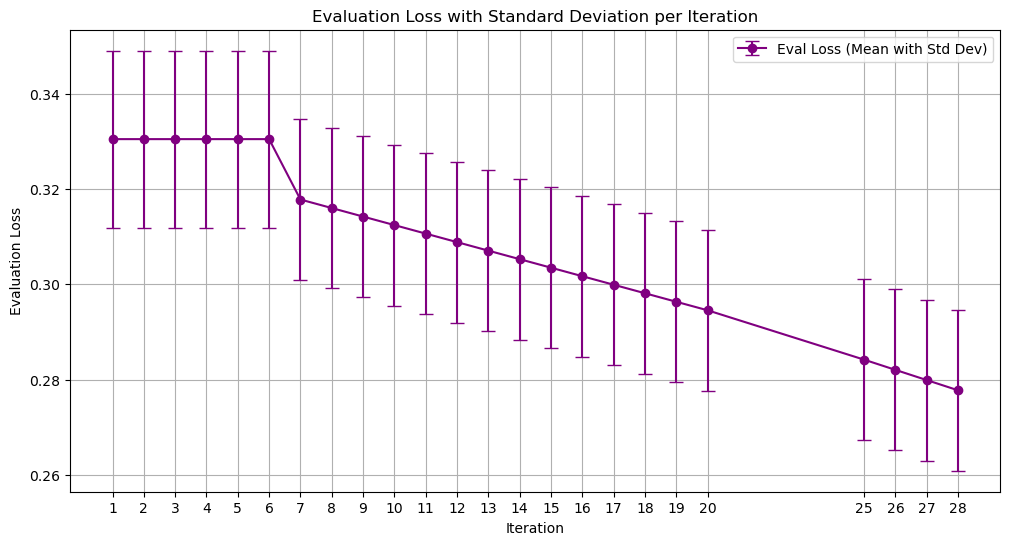

In [11]:
# Plot Evaluation Loss with Standard Deviation
plt.figure(figsize=(12, 6))
plt.errorbar(stats.index, stats['mean'], yerr=stats['std'], fmt='-o', capsize=5, label='Eval Loss (Mean with Std Dev)', color='purple')
plt.xlabel('Iteration')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss with Standard Deviation per Iteration')
plt.xticks(stats.index)  
plt.legend()
plt.grid(True)
plt.savefig('/Users/ratisturua/Desktop/Rati Sturua Individual Project/Helsinki-marianMT/outputs/graphs/eval_loss_std_dev.png')
plt.show()

In [1]:
# Evaluate the average precision at different n-gram levels over iterations
def plot_precisions(evaluation_data):
    precisions = np.array(evaluation_data['precisions'].tolist())  # Convert precisions column to a numpy array for easy indexing
    avg_precisions = precisions.mean(axis=0)  # Calculate the average precision for each n-gram level
    n_gram_levels = [f"{i+1}-gram" for i in range(precisions.shape[1])]  # Create labels for the n-gram levels

    plt.figure(figsize=(10, 5))
    plt.bar(n_gram_levels, avg_precisions, color='skyblue')
    plt.xlabel('N-gram Level')
    plt.ylabel('Average Precision')
    plt.title('Average Precision at Different N-gram Levels')
    plt.show()

# Plot BLEU score trend over iterations
def plot_bleu_scores(evaluation_data):
    plt.figure(figsize=(10, 5))
    plt.plot(evaluation_data['iteration'], evaluation_data['score'], marker='o', linestyle='-', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Score Over Iterations')
    plt.grid(True)
    plt.show()

# Analyzing system length against reference length to see if the model is generating translations of appropriate length
def plot_system_vs_reference_length(evaluation_data):
    plt.figure(figsize=(10, 5))
    plt.scatter(evaluation_data['sys_len'], evaluation_data['ref_len'], alpha=0.5)
    plt.plot([evaluation_data['sys_len'].min(), evaluation_data['sys_len'].max()], [evaluation_data['ref_len'].min(), evaluation_data['ref_len'].max()], 'r--')  # Diagonal line for reference
    plt.xlabel('System Length')
    plt.ylabel('Reference Length')
    plt.title('System Length vs. Reference Length')
    plt.grid(True)
    plt.show()

# Execute the plotting functions
plot_precisions(evaluation_data)
plot_bleu_scores(evaluation_data)
plot_system_vs_reference_length(evaluation_data)


NameError: name 'evaluation_data' is not defined